<h1><center>GLM Site 153</center></h1>



### Import all the packages that we need 


In [3]:
options(warn = -1)
library(caret)
library(dplyr)
library(DMwR)
library(unbalanced)
library(ROCR)
library(corrplot)

### Set working directory and load data

In [13]:
setwd("/Users/sunmengnan/Documents/Github2/thgfd/data/stratified")
glm_data <- read.csv("dataset_153.csv")
glm_data <- select(glm_data, -Site_Key, -Ordered_Product_Key)
head(glm_data)

Category_Level_2Accessories,Category_Level_2Bags,Category_Level_2Beauty.Boxes,Category_Level_2Body.Care,Category_Level_2Books,Category_Level_2Clothing,Category_Level_2DVD.and.Blu.Ray,Category_Level_2Footwear,Category_Level_2Fragrance,Category_Level_2Games,⋯,num_valid,count,prop,customer_status,canc_prop,ship_status,fraud_status,destination_int,priority_int,occupation_int
0,0,0,0,0,0,0,0,0,0,⋯,1,1,1.0,2,0,1,0,2,1,1
0,0,0,0,0,0,0,0,0,0,⋯,1,1,1.0,2,0,1,0,2,1,1
0,0,0,0,0,0,1,0,0,0,⋯,12,15,0.8,2,0,1,0,2,1,1
0,0,0,0,0,0,1,0,0,0,⋯,12,15,0.8,2,0,1,0,2,1,1
0,0,0,0,0,0,1,0,0,0,⋯,12,15,0.8,2,0,1,0,2,1,1
0,0,0,0,0,0,0,0,0,1,⋯,0,1,0.0,3,1,1,0,1,1,1


### Removing zero variance variables

In [14]:
glm_data <- Filter(function(x) var(x)!=0, glm_data)


glm_data <- select(glm_data, -(1:19), -Campaign_Key, -Ordered_Qty, -Cancelled_Qty, -prop,
                   -canc_prop, -count)

In [17]:
glm_data <- select(glm_data, -Medium_Key, -pay_key_num, -Payment_Provider_Key,
                   -Payment_Method_Key, -Delivery_Option_Type_Key, -Order_Payment_Status_Key,
                   -num_valid, -Order_Sequence_No, -priority_int)

### Firstly, in the data cleaning process, use the Tlink to find the nearest point between fraud and non-fraud instance, which should be considered as noise and remove these data, show the sum of fraud counts, the number decreases

In [15]:
set.seed(123)
Tomek <- ubTomek(select(glm_data, -fraud_status), glm_data$fraud_status, verbose = TRUE)
glm_data <- cbind(Tomek$X, Tomek$Y)
glm_data <- rename(glm_data, fraud_status = "Tomek$Y")



Instances removed 43 : 0.13 % of 0 class ; 0.13 % of training ; Time needed 0.09 


### Test for colinearity

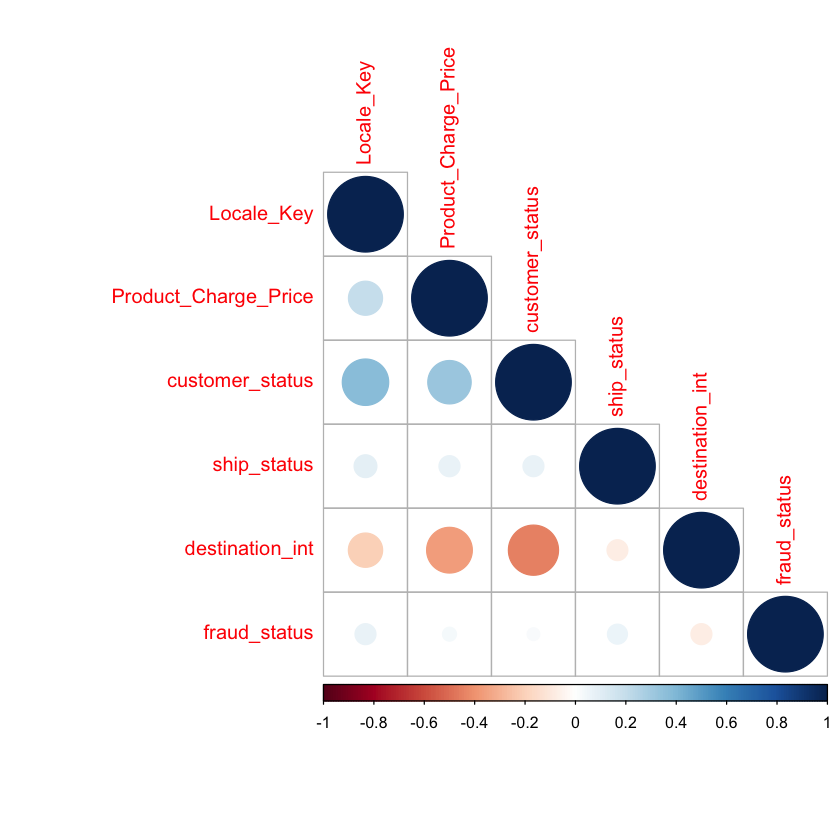

In [18]:
X <- cor(glm_data)
corrplot(X, method="circle", type = "lower")


### Turn into factors


In [20]:
temp <- select(glm_data, -Product_Charge_Price)
temp[,(1:ncol(temp))] <- lapply(temp[,(1:ncol(temp))],as.factor)
nums <- select(glm_data, Product_Charge_Price)
glm_data <- cbind(temp, nums)

### Create a partition to seperate the data into training part and test part



In [21]:
new_data <- glm_data
set.seed(123)
index <- createDataPartition(new_data$fraud_status, p = 0.6, list = FALSE)
train <- new_data[index, ]
test <- new_data[-index, ]

### Firstly, in the data cleaning process, use the Tlink to find the nearest point between fraud and non-fraud instance, which should be considered as noise and remove these data, show the sum of fraud counts, the number decreases

In [22]:
set.seed(123)
train <- SMOTE(fraud_status ~., train, perc.over = 1000, perc.under = 150)
table(train$fraud_status)
prop.table(table(train$fraud_status))


  0   1 
930 682 


        0         1 
0.5769231 0.4230769 

### Build a GLM model

In [24]:
start <- Sys.time()
model <- glm(fraud_status ~.-1, data = train, family = binomial(link = "logit"))
end <- Sys.time()
time <- end - start
time
summary(model)

Time difference of 0.04837203 secs


Call:
glm(formula = fraud_status ~ . - 1, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7942  -0.6347  -0.3554   0.4888   2.3073  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
Locale_Key2            2.606964   0.528978   4.928 8.29e-07 ***
Locale_Key6            3.854747   0.511961   7.529 5.10e-14 ***
Locale_Key9          -11.388403 328.603172  -0.035    0.972    
Locale_Key12           4.424169   0.529951   8.348  < 2e-16 ***
customer_status2      -3.404575   0.485129  -7.018 2.25e-12 ***
customer_status3      -3.429645   0.594018  -5.774 7.76e-09 ***
customer_status4      -2.120443   0.513115  -4.132 3.59e-05 ***
ship_status2           2.129491   0.227323   9.368  < 2e-16 ***
destination_int2      -1.983494   0.176917 -11.211  < 2e-16 ***
Product_Charge_Price   0.006736   0.001728   3.899 9.66e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(D

### Use our model to test our test data set, calculate the curve area value

[1] 0.881642

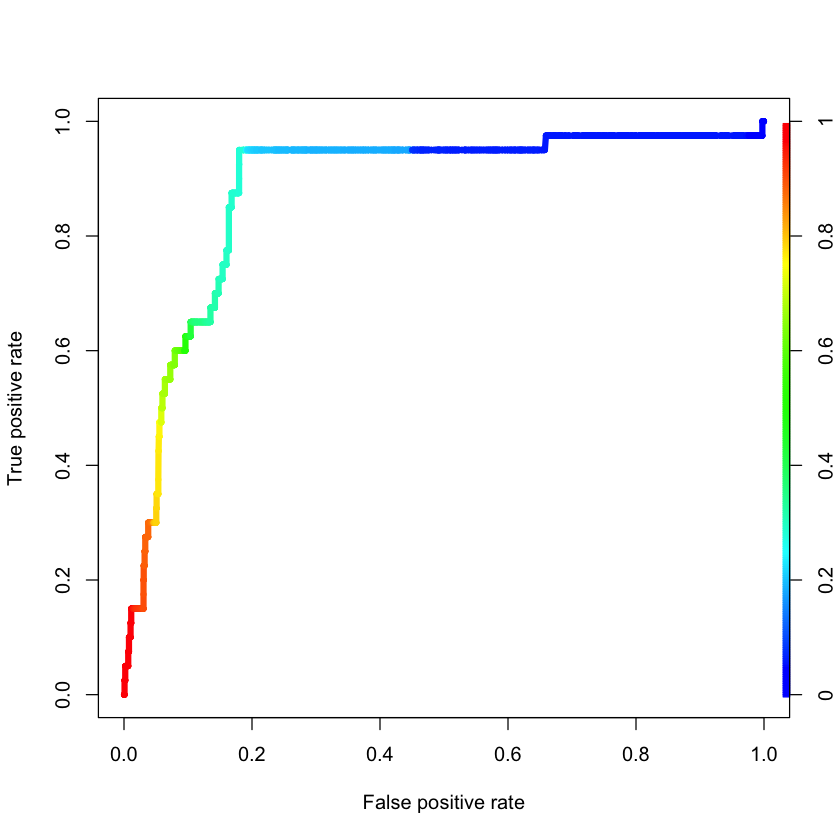

In [25]:
model_predict <- predict(model, test, type = "response")
ROC_predict <- prediction(model_predict, test$fraud_status)
ROC_performance <- performance(ROC_predict, "tpr", "fpr")
plot(ROC_performance, colorize = TRUE, text.adj = c(-0.2,1.7), lwd = 5)
area_under_curve <- performance(ROC_predict, measure = "auc")
area_under_curve@y.values[[1]]


In [26]:
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)
model_fit <- caret::train(fraud_status ~ customer_status + Product_Charge_Price +
                            ship_status + destination_int + Locale_Key,
                   data = train, method = "glm", family = binomial(link ="logit"),
                   trControl = ctrl, tuneLength = 10)
pred <- predict(model_fit, newdata = test)
conf <- confusionMatrix(data = pred, test$fraud_status)
conf
conf$byClass

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 11603    15
         1  1249    25
                                         
               Accuracy : 0.902          
                 95% CI : (0.8967, 0.907)
    No Information Rate : 0.9969         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0322         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.90282        
            Specificity : 0.62500        
         Pos Pred Value : 0.99871        
         Neg Pred Value : 0.01962        
             Prevalence : 0.99690        
         Detection Rate : 0.90002        
   Detection Prevalence : 0.90118        
      Balanced Accuracy : 0.76391        
                                         
       'Positive' Class : 0              
                                         

Sensitivity          Specificity       Pos Pred Value 
          0.90281668           0.62500000           0.99870890 
      Neg Pred Value            Precision               Recall 
          0.01962323           0.99870890           0.90281668 
                  F1           Prevalence       Detection Rate 
          0.94834491           0.99689730           0.90001551 
Detection Prevalence    Balanced Accuracy 
          0.90117903           0.76390834